# Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib as mpl
import seaborn as sns
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from sklearn import preprocessing, ensemble, metrics, linear_model, model_selection, inspection, cluster
# import semopy
import datetime as dt
from scipy import interpolate
from tqdm import tqdm
from pprint import pprint
import json
from shapely.geometry import box, mapping
from functools import partial
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata, rasterize_points_radial
from affine import Affine
import pickle
import quantile_forest as qrf
# import cv2

import warnings
warnings.filterwarnings("ignore")

D:\dev\Anaconda3\envs\pygeo\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.10.1-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


# Functions

# Global mapping

## Generate dataframes and maps of global predictions

In [ ]:
df_top = pd.read_csv('./results/df_samples_topsoil_with_covariates_v6.csv')
df_sub = pd.read_csv('./results/df_samples_subsoil_with_covariates_v6.csv')

In [7]:
top_or_sub = 'topsoil'
# top_or_sub = 'subsoil'

if top_or_sub == 'topsoil':
    df = df_top
else:
    df = df_sub

In [8]:
df_all = pd.read_csv('./data/gee_data/df_all/df_all.csv')
print(df_all.shape)
print(list(df_all.columns))
df_all.head()

(1530834, 27)
['ID', 'tovr_top', 'tovr_sub', 'bio01', 'bio12', 'clay_0to30', 'sand_0to30', 'silt_0to30', 'nitrogen_0to30', 'ph_0to30', 'cec_0to30', 'clay_30to100', 'sand_30to100', 'silt_30to100', 'nitrogen_30to100', 'ph_30to100', 'cec_30to100', 'elev', 'slp', 'vrm', 'roughness', 'cti', 'tri', 'tpi', 'spi', 'y', 'x']


,ID,tovr_top,tovr_sub,bio01,bio12,clay_0to30,sand_0to30,silt_0to30,nitrogen_0to30,ph_0to30,...,elev,slp,vrm,roughness,cti,tri,tpi,spi,y,x
0,645688,152.0000,519.148130,49.0,217.0,219.83333,344.00000,435.666660,3482.0000,77.500000,...,138,1.174054,7.909870e-06,5.115635,0.106233,1.713139,0.398125,0.001383,49.721751,63.016817
1,1367862,10.4375,27.242714,201.0,1378.0,149.83333,780.33330,69.333336,574.8333,53.166668,...,1283,7.080985,4.848555e-03,28.483713,2.437305,10.606007,-5.051510,0.351297,-11.363688,18.280716
2,552670,179.0000,418.768400,25.0,356.0,256.50000,380.83334,363.000000,3044.8333,70.333336,...,230,0.189014,5.479619e-06,1.243149,0.249062,0.429533,-0.309961,0.000293,53.225181,61.759176
3,1158972,203.0000,463.525570,276.0,814.0,342.33334,400.50000,256.666660,1749.1666,63.500000,...,392,0.018734,1.069231e-07,0.220526,0.864880,0.063012,0.005152,0.000288,9.207732,30.497804
4,1117936,101.0000,372.123380,274.0,491.0,288.33334,393.16666,318.666660,838.0000,72.333336,...,656,0.556685,2.742446e-05,3.099982,-0.393885,1.119258,0.718642,0.000316,13.339982,21.514651


In [9]:
gdf = gpd.GeoDataFrame(df[['profile_id', 'latitude', 'longitude', 'biome_type', 'ECO_ID', 'BIOME_NUM', 'tovr', 'tovr_log']].reset_index(drop=True), geometry=gpd.points_from_xy(df['longitude'], df['latitude']), crs='EPSG:4326')
gdf_all = gpd.GeoDataFrame(df_all, geometry=gpd.points_from_xy(df_all['x'], df_all['y']), crs='EPSG:4326')

gdf = gpd.sjoin_nearest(gdf, gdf_all).reset_index(drop=True)
print(list(gdf.columns))
gdf.head()

['profile_id', 'latitude', 'longitude', 'biome_type', 'ECO_ID', 'BIOME_NUM', 'tovr', 'tovr_log', 'geometry', 'index_right', 'ID', 'tovr_top', 'tovr_sub', 'bio01', 'bio12', 'clay_0to30', 'sand_0to30', 'silt_0to30', 'nitrogen_0to30', 'ph_0to30', 'cec_0to30', 'clay_30to100', 'sand_30to100', 'silt_30to100', 'nitrogen_30to100', 'ph_30to100', 'cec_30to100', 'elev', 'slp', 'vrm', 'roughness', 'cti', 'tri', 'tpi', 'spi', 'y', 'x']


,profile_id,latitude,longitude,biome_type,ECO_ID,BIOME_NUM,tovr,tovr_log,geometry,index_right,...,elev,slp,vrm,roughness,cti,tri,tpi,spi,y,x
0,36897,50.649889,4.666901,8,664,4.0,3.784502,0.578009,POINT (4.66690 50.64989),71012,...,122,0.806496,0.000177,5.148474,-1.415844,2.210682,2.050585,0.000142,50.620066,4.626324
1,36902,50.610517,4.619128,8,664,4.0,3.630565,0.559974,POINT (4.61913 50.61052),71012,...,122,0.806496,0.000177,5.148474,-1.415844,2.210682,2.050585,0.000142,50.620066,4.626324
2,36976,50.586921,4.644345,8,664,4.0,3.483064,0.541961,POINT (4.64435 50.58692),71012,...,122,0.806496,0.000177,5.148474,-1.415844,2.210682,2.050585,0.000142,50.620066,4.626324
3,36977,50.590364,4.590247,8,664,4.0,3.582646,0.554204,POINT (4.59025 50.59036),71012,...,122,0.806496,0.000177,5.148474,-1.415844,2.210682,2.050585,0.000142,50.620066,4.626324
4,36978,50.611674,4.620907,8,664,4.0,3.643238,0.561488,POINT (4.62091 50.61167),71012,...,122,0.806496,0.000177,5.148474,-1.415844,2.210682,2.050585,0.000142,50.620066,4.626324


In [10]:
x_names = [
    'bio01', 'bio12',
    'clay_0to30', 'sand_0to30', 'silt_0to30', 'nitrogen_0to30', 'ph_0to30', 'cec_0to30',
    'clay_30to100', 'sand_30to100', 'silt_30to100', 'nitrogen_30to100', 'ph_30to100', 'cec_30to100',
    'elev', 'slp', 'vrm', 'roughness', 'cti', 'tri', 'tpi', 'spi'
]
y_name = 'tovr'

In [15]:
x = gdf[x_names]
y = gdf[y_name]
x_all = df_all[x_names]

model = qrf.RandomForestQuantileRegressor()
model.fit(x, y)

y_pred_mean = model.predict(x, quantiles=None)
# y_pred_quantiles = model.predict(x, quantiles=[0.025, 0.5, 0.975])
y_pred_quantiles = model.predict(x, quantiles=[0.25, 0.5, 0.75])

print(metrics.r2_score(y, y_pred_mean))
print(np.sqrt(metrics.mean_squared_error(y, y_pred_mean)))

0.8262861657641252
14.08866010356894


In [16]:
y_pred_all_mean = model.predict(x_all, quantiles=None)
y_pred_all_quantiles = model.predict(x_all, quantiles=[0.25, 0.5, 0.75])

print(y_pred_all_mean.shape, y_pred_all_quantiles.shape)

(1530834,) (1530834, 3)


In [17]:
df_all['tovr_pred_mean'] = y_pred_all_mean
df_all['tovr_pred_lower'] = y_pred_all_quantiles[:, 0]
df_all['tovr_pred_median'] = y_pred_all_quantiles[:, 1]
df_all['tovr_pred_upper'] = y_pred_all_quantiles[:, 2]
df_all['tovr_pred_PI'] = df_all['tovr_pred_upper'] - df_all['tovr_pred_lower']
df_all['tovr_pred_unc'] = df_all['tovr_pred_PI'] / df_all['tovr_pred_median']

if top_or_sub == 'topsoil':
    df_all['tovr_pred_unc'] = df_all['tovr_pred_unc'] * 100 * 0.5
else:
    df_all['tovr_pred_unc'] = df_all['tovr_pred_unc'] * 100 * 0.3

print(df_all.shape)
print(list(df_all.columns))

(1530834, 34)
['ID', 'tovr_top', 'tovr_sub', 'bio01', 'bio12', 'clay_0to30', 'sand_0to30', 'silt_0to30', 'nitrogen_0to30', 'ph_0to30', 'cec_0to30', 'clay_30to100', 'sand_30to100', 'silt_30to100', 'nitrogen_30to100', 'ph_30to100', 'cec_30to100', 'elev', 'slp', 'vrm', 'roughness', 'cti', 'tri', 'tpi', 'spi', 'y', 'x', 'mask_npp', 'tovr_pred_mean', 'tovr_pred_lower', 'tovr_pred_median', 'tovr_pred_upper', 'tovr_pred_PI', 'tovr_pred_unc']


In [18]:
# df_all.to_csv('./results/df_all_pred_topsoil.csv', index=False)
# df_all.to_csv('./results/df_all_pred_subsoil.csv', index=False)

In [11]:
df_pred = pd.read_csv('./results/df_all_pred_topsoil.csv')
# df_pred = pd.read_csv('./results/df_all_pred_subsoil.csv')

print(df_pred.shape)
print(list(df_pred.columns))

(1530834, 34)
['ID', 'tovr_top', 'tovr_sub', 'bio01', 'bio12', 'clay_0to30', 'sand_0to30', 'silt_0to30', 'nitrogen_0to30', 'ph_0to30', 'cec_0to30', 'clay_30to100', 'sand_30to100', 'silt_30to100', 'nitrogen_30to100', 'ph_30to100', 'cec_30to100', 'elev', 'slp', 'vrm', 'roughness', 'cti', 'tri', 'tpi', 'spi', 'y', 'x', 'mask_npp', 'tovr_pred_mean', 'tovr_pred_lower', 'tovr_pred_median', 'tovr_pred_upper', 'tovr_pred_PI', 'tovr_pred_unc']


In [12]:
gdf_pred = gpd.GeoDataFrame(df_pred, geometry=gpd.points_from_xy(df_pred['x'], df_pred['y']), crs=4326)
print(gdf_pred.shape)
gdf_pred.head(2)

(1530834, 35)


,ID,tovr_top,tovr_sub,bio01,bio12,clay_0to30,sand_0to30,silt_0to30,nitrogen_0to30,ph_0to30,...,y,x,mask_npp,tovr_pred_mean,tovr_pred_lower,tovr_pred_median,tovr_pred_upper,tovr_pred_PI,tovr_pred_unc,geometry
0,645688,152.0000,519.148130,49.0,217.0,219.83333,344.0000,435.666660,3482.0000,77.500000,...,49.721751,63.016817,1,33.998615,16.972528,33.998615,63.061428,46.088900,67.780554,POINT (63.01682 49.72175)
1,1367862,10.4375,27.242714,201.0,1378.0,149.83333,780.3333,69.333336,574.8333,53.166668,...,-11.363688,18.280716,1,9.863142,9.863142,9.863142,10.668520,0.805378,4.082766,POINT (18.28072 -11.36369)


## Plot global SOC turnover time map

0.0  34766.8  386.2  89.4


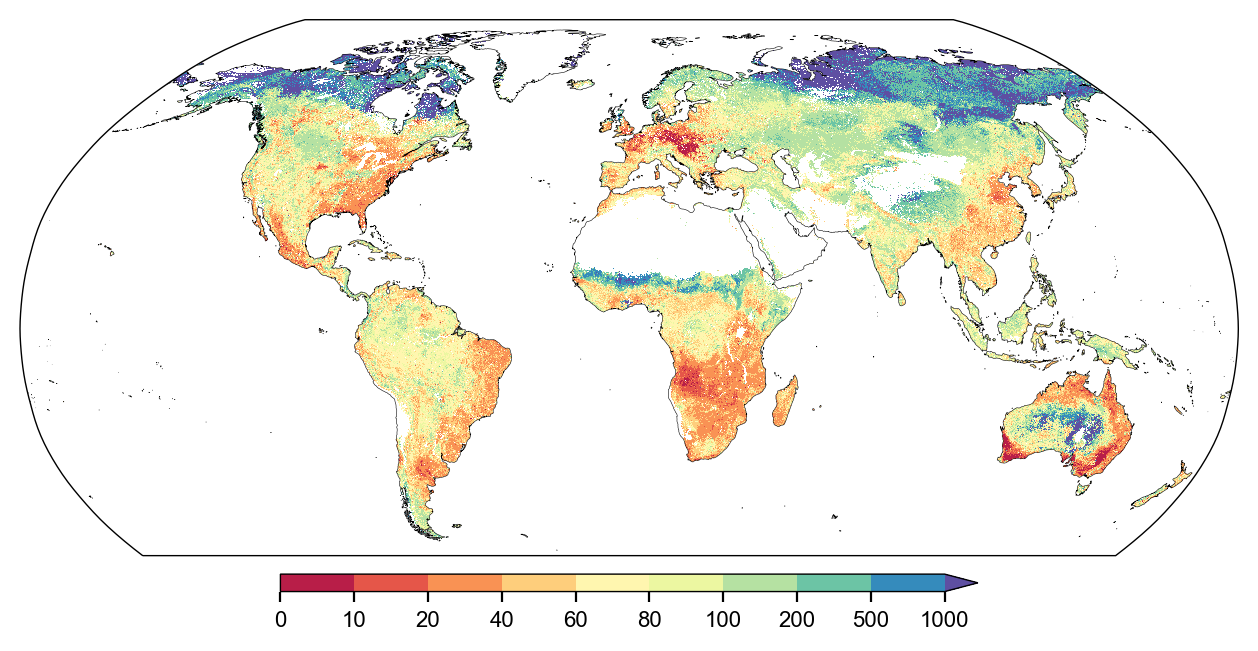

In [82]:
# map_pred = xr.open_rasterio('./results/predmaps_QRF/pred_map_topsoil_QRF_tovr_pred_mean_rm_organic_soil.tif')
map_pred = xr.open_rasterio('./results/predmaps_QRF/pred_map_subsoil_QRF_tovr_pred_mean_rm_organic_soil.tif')

# map_pred.values = np.exp(10, map_pred.values, where=~np.isnan(map_pred.values))

map_pred.close()
print('{:.1f}  {:.1f}  {:.1f}  {:.1f}'.format(np.nanmin(map_pred.values), np.nanmax(map_pred.values), np.nanmean(map_pred.values), np.nanmedian(map_pred.values)))

# vmin = 0
# vmax = 100
# levels = [0, 10, 20, 30, 40, 50, 60, 70, 80]

vmin = 0
vmax = 300
levels = [0, 10, 20, 40, 60, 80, 100, 200, 500, 1000]

# crs = ccrs.PlateCarree(central_longitude=0.0, globe=None)
crs = ccrs.Robinson(central_longitude=0, globe=None)

plt.rc('font', family='Arial', size=12)
plt.rcParams['axes.linewidth'] = 0.5
plt.rc('lines', linewidth=0.3)

fig = plt.figure(figsize=(9, 4), dpi=200, linewidth=0.1, frameon=False)
ax = fig.add_subplot(111, projection=crs)
ax._autoscaleXon = False
ax._autoscaleYon = False

# ax.add_feature(cfeature.LAND, color='#E0E0E0', linewidth=0)
ax.coastlines("50m", color="black", linewidth=0.2)

norm = mpl.colors.Normalize(vmin, vmax)
cmap = plt.cm.get_cmap('Spectral')
cmap = truncate_colormap(cmap, 0.05, 1)  # use this when ploting subsoil turnover time

im = map_pred[0].plot(ax=ax, cmap=cmap, transform=ccrs.PlateCarree(), levels=levels, add_labels=False, add_colorbar=False)

cb = plt.colorbar(im, orientation="horizontal", fraction=0.1, aspect=40, shrink=0.5, ticks=levels, pad=0.03)
cb.set_label(label='', size=8)
cb.ax.tick_params(labelsize=8)

# ax.set_global()
extent=[-179.999, 179.999, -60, 90]
ax.set_extent(extent, crs=ccrs.PlateCarree())

plt.savefig('./figure/predmap_tovr_{}_robin_test.jpg'.format(top_or_sub), dpi=600, bbox_inches='tight')
plt.show()